In [ ]:
!pip install torch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
class MyDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __getitem__(self, index):
        row = self.data.iloc[index]
        x = row.iloc[:-1].values.astype(float)
        y = row.iloc[-1]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

def transform(x):
    return torch.from_numpy(x)


In [ ]:
dataset = MyDataset(r'C:\Users\manar\Downloads\Finger\Fingers_Train_S5.csv', transform=transform)
train_dataset , val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=2000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2000, shuffle=False)


In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1 , padding = 1),
            nn.BatchNorm1d(32) ,
            nn.GELU() ,

            nn.Conv1d(32 , 64 , kernel_size = 3 , stride = 1 , padding = 1) ,
            nn.BatchNorm1d(64) ,
            nn.GELU() ,
            nn.MaxPool1d(3),

            nn.Conv1d(64 , 128 , kernel_size = 3 , stride = 1 , padding = 1) ,
            nn.BatchNorm1d(128) ,
            nn.GELU() ,
            nn.MaxPool1d(3) ,

            nn.Conv1d(128 , 256 , kernel_size = 3 , stride = 1 , padding = 1) ,
            nn.BatchNorm1d(256) ,
            nn.GELU() ,
            nn.Dropout(0.6))
        
        self.linear = nn.Sequential(
            nn.Linear(7168,512) ,
            nn.Dropout(0.5) ,
            nn.LeakyReLU(inplace = True) ,
            nn.Linear(512 , 6)
        )

    def forward(self,x):
        x = x.unsqueeze(1)
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x



In [ ]:
model = MyModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)


In [ ]:
import wandb
wandb.util.get_module('sys')._executable = r'C:\Users\manar\AppData\Local\Programs\Python\Python310\python.exe'

In [ ]:
wandb.init(project = "EEGSignals" , entity = "manar")
id = wandb.util.generate_id()


wandb: Currently logged in as: manar. Use `wandb login --relogin` to force relogin


In [ ]:
print(id)

6rs8vb0o


In [ ]:
!mkdir grievous-fleet-123

In [ ]:
num_epochs = 300
early_stopping_patience = 15

best_val_loss = float('inf')
best_model = None
early_stopping_counter = 0


In [ ]:
EXPERMENT_NAME = 'grievous-fleet-123'
CHECKPOINT_PATH = f'C:\\Users\\manar\\{EXPERMENT_NAME}\\model.pt'

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_correct = 0
    val_correct = 0
    train_total = 0
    val_total = 0

    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs.float())
            loss = criterion(outputs, labels.long())
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss) 
    val_accuracies.append(val_acc)

    print({'epoch': epoch+1, 'loss': train_loss, 'val_loss': val_loss, 'accuracy': train_acc, 'val_accuracy': val_acc})

    wandb.log({'epoch': epoch+1, 'loss': train_loss, 'val_loss': val_loss, 'accuracy': train_acc, 'val_accuracy': val_acc})

    torch.save({ 
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        }, CHECKPOINT_PATH)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    
    if early_stopping_counter >= early_stopping_patience:
        print("Stopping early at epoch:", epoch)
        break



{'epoch': 1, 'loss': 1.725936530587765, 'val_loss': 1.6562591791152954, 'accuracy': 0.2083573717948718, 'val_accuracy': 0.23697916666666666}
{'epoch': 2, 'loss': 1.6394517814310698, 'val_loss': 1.5992255684656975, 'accuracy': 0.23970152243589743, 'val_accuracy': 0.2633974358974359}
{'epoch': 3, 'loss': 1.6071681100397537, 'val_loss': 1.572217229467172, 'accuracy': 0.2546013621794872, 'val_accuracy': 0.2730448717948718}
{'epoch': 4, 'loss': 1.5789586591223876, 'val_loss': 1.5319080987037756, 'accuracy': 0.2678986378205128, 'val_accuracy': 0.2897275641025641}
{'epoch': 5, 'loss': 1.5431710151143563, 'val_loss': 1.4902342091768215, 'accuracy': 0.2864102564102564, 'val_accuracy': 0.31584935897435895}
{'epoch': 6, 'loss': 1.5153552093184912, 'val_loss': 1.4671655591481771, 'accuracy': 0.3025140224358974, 'val_accuracy': 0.3252003205128205}
{'epoch': 7, 'loss': 1.4888156979129865, 'val_loss': 1.4392204040136092, 'accuracy': 0.3159635416666667, 'val_accuracy': 0.34650641025641027}
{'epoch': 8

{'epoch': 60, 'loss': 0.9533081318323429, 'val_loss': 0.7819916414908874, 'accuracy': 0.5902644230769231, 'val_accuracy': 0.6969551282051282}
{'epoch': 61, 'loss': 0.9530702090034118, 'val_loss': 0.7857144316419576, 'accuracy': 0.5910957532051282, 'val_accuracy': 0.7019791666666667}
{'epoch': 62, 'loss': 0.941837103273242, 'val_loss': 0.7839101079182748, 'accuracy': 0.595985576923077, 'val_accuracy': 0.7047115384615384}
{'epoch': 63, 'loss': 0.9401633692666506, 'val_loss': 0.7737982827119338, 'accuracy': 0.5968689903846154, 'val_accuracy': 0.7090945512820512}
{'epoch': 64, 'loss': 0.9370741479767438, 'val_loss': 0.7692732302806317, 'accuracy': 0.5985076121794872, 'val_accuracy': 0.7137900641025641}
{'epoch': 65, 'loss': 0.9335438747627612, 'val_loss': 0.7631530950848873, 'accuracy': 0.6005328525641026, 'val_accuracy': 0.7128846153846153}
{'epoch': 66, 'loss': 0.9270538351474664, 'val_loss': 0.7466844939268552, 'accuracy': 0.6029326923076923, 'val_accuracy': 0.7191105769230769}
{'epoch'

{'epoch': 118, 'loss': 0.7300101764595661, 'val_loss': 0.5100432640084853, 'accuracy': 0.7006911057692308, 'val_accuracy': 0.8356410256410256}
{'epoch': 119, 'loss': 0.7305398518458391, 'val_loss': 0.500296424023616, 'accuracy': 0.6998858173076923, 'val_accuracy': 0.8371233974358975}
{'epoch': 120, 'loss': 0.7297224025600232, 'val_loss': 0.49805837554427296, 'accuracy': 0.7001782852564102, 'val_accuracy': 0.8433733974358975}
{'epoch': 121, 'loss': 0.7222940732175723, 'val_loss': 0.48825650385174996, 'accuracy': 0.7044270833333334, 'val_accuracy': 0.8480689102564103}
{'epoch': 122, 'loss': 0.7233238915602366, 'val_loss': 0.4992745101260833, 'accuracy': 0.7043990384615385, 'val_accuracy': 0.8411698717948718}
{'epoch': 123, 'loss': 0.71561450468233, 'val_loss': 0.4769380871111002, 'accuracy': 0.7065284455128205, 'val_accuracy': 0.8528846153846154}
{'epoch': 124, 'loss': 0.7150371673588569, 'val_loss': 0.4847523522300598, 'accuracy': 0.7073177083333333, 'val_accuracy': 0.8477644230769231}


{'epoch': 176, 'loss': 0.608043214210715, 'val_loss': 0.3548982305786548, 'accuracy': 0.7571734775641026, 'val_accuracy': 0.9036778846153846}
{'epoch': 177, 'loss': 0.6038353514308349, 'val_loss': 0.3504123368706459, 'accuracy': 0.7585897435897436, 'val_accuracy': 0.9046554487179487}
{'epoch': 178, 'loss': 0.5967034026502799, 'val_loss': 0.35006589165482765, 'accuracy': 0.762275641025641, 'val_accuracy': 0.9017067307692308}
{'epoch': 179, 'loss': 0.5960590561422018, 'val_loss': 0.3591501752917583, 'accuracy': 0.7627163461538462, 'val_accuracy': 0.9040464743589743}
{'epoch': 180, 'loss': 0.6011299406870817, 'val_loss': 0.35704031452918666, 'accuracy': 0.7600200320512821, 'val_accuracy': 0.9031650641025641}
{'epoch': 181, 'loss': 0.5915753380037271, 'val_loss': 0.3272188165440009, 'accuracy': 0.7642367788461538, 'val_accuracy': 0.911298076923077}
{'epoch': 182, 'loss': 0.5925215855718423, 'val_loss': 0.3321296952855893, 'accuracy': 0.7632311698717948, 'val_accuracy': 0.9066506410256411}


{'epoch': 234, 'loss': 0.521333661264716, 'val_loss': 0.2806481112463352, 'accuracy': 0.7950620993589743, 'val_accuracy': 0.9243108974358974}
{'epoch': 235, 'loss': 0.5326572759076953, 'val_loss': 0.26954781770324093, 'accuracy': 0.7909455128205128, 'val_accuracy': 0.9345833333333333}
{'epoch': 236, 'loss': 0.5236275726690506, 'val_loss': 0.2552519890073782, 'accuracy': 0.794375, 'val_accuracy': 0.936650641025641}
{'epoch': 237, 'loss': 0.5146773878532724, 'val_loss': 0.27323918412320125, 'accuracy': 0.7982932692307693, 'val_accuracy': 0.9306810897435898}
{'epoch': 238, 'loss': 0.5186493195450077, 'val_loss': 0.2845876090801679, 'accuracy': 0.7968770032051282, 'val_accuracy': 0.9298076923076923}
{'epoch': 239, 'loss': 0.5238045678259089, 'val_loss': 0.270631862231172, 'accuracy': 0.7948357371794872, 'val_accuracy': 0.9339503205128206}
{'epoch': 240, 'loss': 0.5162759707667507, 'val_loss': 0.256184509024024, 'accuracy': 0.7975500801282052, 'val_accuracy': 0.9326121794871794}
{'epoch': 2

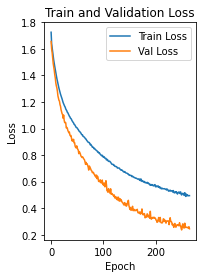

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.show()


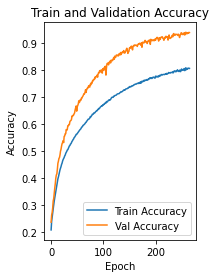

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.show()


In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    return model, optimizer, loss, checkpoint['epoch']


In [ ]:

model = MyModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

model, optimizer, loss, start_epoch = load_ckp("C:\\Users\\manar\\grievous-fleet-123\\model.pt", model, optimizer)


In [ ]:

test_dataset = MyDataset(r'C:\Users\manar\Downloads\Finger\Fingers_Train_S5.csv', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=2000, shuffle=False)



In [ ]:

test_losses = []
test_accuracies = []

model.eval()
test_loss = 0.0
test_correct = 0
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.float())
        loss = criterion(outputs, labels.long())
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

        test_loss /= len(test_dataset)
        test_acc = test_correct / len(test_dataset)

        test_losses.append(test_loss)
        test_accuracies.append(test_acc)


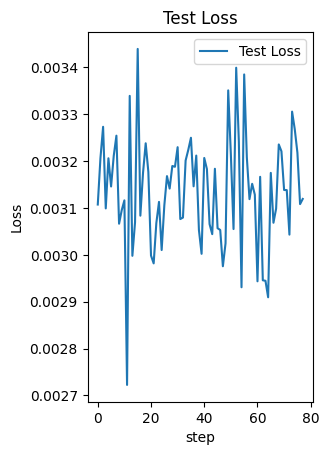

In [ ]:

plt.subplot(1, 2, 2)
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('step')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.show()


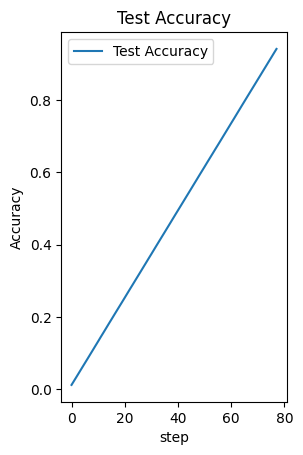

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()
plt.xlabel('step')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.show()


In [ ]:
target_names = ['rest', 'thumb', 'index', 'middle', 'ring', 'little'] 

In [ ]:
print(classification_report(y_true, y_pred, target_names=target_names))


              precision    recall  f1-score   support

        rest       1.00      0.97      0.98      6066
       thumb       0.96      0.94      0.95     29998
       index       0.94      0.93      0.94     30034
      middle       0.95      0.93      0.94     30067
        ring       0.91      0.96      0.94     29712
      little       0.93      0.94      0.93     30123

    accuracy                           0.94    156000
   macro avg       0.95      0.95      0.95    156000
weighted avg       0.94      0.94      0.94    156000



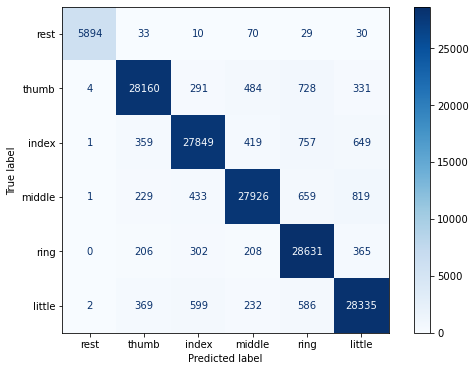

In [ ]:
cm = confusion_matrix(y_true, y_pred)

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(9, 6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=cmap, ax=ax)
plt.show()
